<a href="https://colab.research.google.com/github/Vinit0812/Image-Segmentation-Using-U-Net/blob/main/Image_Segmenation_Using_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Download and extract dataset
# Download and extract the VOC2012 dataset
!curl -L -o VOCtrainval_11-May-2012.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1907M  100 1907M    0     0  21.8M      0  0:01:27  0:01:27 --:--:-- 18.9M


In [ ]:
# Cell 2: Fixed data augmentation and dataset creation
import tensorflow as tf
import numpy as np
import os
import cv2
from glob import glob
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

# VOC Color Map
VOC_COLORMAP = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]], dtype=np.uint8)

# Convert RGB mask to class indices
def rgb_to_class_indices(mask_rgb):
    h, w = mask_rgb.shape[:2]
    mask_indices = np.zeros((h, w), np.uint8)
    for class_idx, color in enumerate(VOC_COLORMAP):
        mask_indices[np.all(mask_rgb == color, axis=-1)] = class_idx
    return mask_indices

# Convert class indices to RGB mask
def class_indices_to_rgb(mask_indices):
    return VOC_COLORMAP[mask_indices]

# Load image and mask
def load_image(image_path, mask_path, img_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)
    image = image.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = rgb_to_class_indices(mask)
    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    return image, mask

# Get image-mask pairs
def get_image_mask_pairs(base_path='.'):
    image_dir = os.path.join(base_path, 'VOCdevkit/VOC2012/JPEGImages')
    mask_dir = os.path.join(base_path, 'VOCdevkit/VOC2012/SegmentationClass')

    mask_paths = glob(os.path.join(mask_dir, '*.png'))
    image_paths = []
    for mask_path in mask_paths:
        base_name = os.path.basename(mask_path)
        image_path = os.path.join(image_dir, base_name.replace('.png', '.jpg'))
        if os.path.exists(image_path):
            image_paths.append(image_path)
    return image_paths, mask_paths

# Data augmentation
def augment_data(image, mask):
    flip_lr = tf.random.uniform([]) > 0.5
    image = tf.cond(flip_lr, lambda: tf.image.flip_left_right(image), lambda: image)
    mask = tf.cond(flip_lr, lambda: tf.reverse(mask, [1]), lambda: mask)

    flip_ud = tf.random.uniform([]) > 0.5
    image = tf.cond(flip_ud, lambda: tf.image.flip_up_down(image), lambda: image)
    mask = tf.cond(flip_ud, lambda: tf.reverse(mask, [0]), lambda: mask)

    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, mask

# Create dataset
def create_dataset(image_paths, mask_paths, batch_size=32, augment=False):
    def generator():
        for img_path, mask_path in zip(image_paths, mask_paths):
            image, mask = load_image(img_path, mask_path)
            yield image, mask

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(128, 128), dtype=tf.uint8)
        )
    )

    if augment:
        # Apply augmentation with shape enforcement
        dataset = dataset.map(
            lambda x, y: tf.py_function(
                augment_data,
                [x, y],
                Tout=(tf.float32, tf.uint8)
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: (tf.ensure_shape(x, (128, 128, 3)), tf.ensure_shape(y, (128, 128))),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Cell 3: Load and split dataset
# Load image-mask pairs
image_paths, mask_paths = get_image_mask_pairs('.')
n_samples = len(image_paths)
n_train = int(0.9 * n_samples)
train_image_paths, train_mask_paths = image_paths[:n_train], mask_paths[:n_train]
val_image_paths, val_mask_paths = image_paths[n_train:], mask_paths[n_train:]

# Create datasets
BATCH_SIZE = 32
train_dataset = create_dataset(train_image_paths, train_mask_paths, batch_size=BATCH_SIZE, augment=True)
val_dataset = create_dataset(val_image_paths, val_mask_paths, batch_size=BATCH_SIZE, augment=False)

print(f"Total samples: {n_samples}")
print(f"Training samples: {n_train}")
print(f"Validation samples: {n_samples - n_train}")

Total samples: 2913
Training samples: 2621
Validation samples: 292


In [ ]:
# Cell 4: Deeper U-Net architecture
# Define a deeper U-Net model with 3 down/up-sampling blocks
def unet_model(input_size=(128, 128, 3), n_classes=21):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    b1 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    b1 = Conv2D(512, (3,3), activation='relu', padding='same')(b1)

    # Decoder
    u4 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(b1)
    u4 = concatenate([u4, c3])
    c4 = Conv2D(256, (3,3), activation='relu', padding='same')(u4)
    c4 = Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c2])
    c5 = Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c1])
    c6 = Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3,3), activation='relu', padding='same')(c6)

    outputs = Conv2D(n_classes, (1,1), activation='softmax')(c6)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
# Cell 5: Class weights and model compilation
# Compute class weights using training data
train_masks = []
for images, masks in train_dataset:
    train_masks.extend(masks.numpy().flatten())
class_labels = np.unique(train_masks)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_masks)

# Custom loss function with class weights
def weighted_sparse_categorical_crossentropy(y_true, y_pred):
    y_true_int = tf.cast(y_true, tf.int32)
    weights = tf.gather(tf.constant(class_weights, dtype=tf.float32), y_true_int)  # Cast to float32
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weights

# Build and compile model
model = unet_model()
model.compile(optimizer='adam', loss=weighted_sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# Cell 6: Train the model
# Train with increased epochs and learning rate scheduler
def lr_scheduler(epoch, lr):
    return lr * 0.9 if epoch % 5 == 0 else lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler)]
history = model.fit(train_dataset, epochs=14, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/14
     82/Unknown 313s 3s/step - accuracy: 0.0130 - loss: 3.0235

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


82/82 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.0131 - loss: 3.0236 - val_accuracy: 0.0161 - val_loss: 2.8282 - learning_rate: 9.0000e-04
Epoch 2/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.0336 - loss: 2.9645 - val_accuracy: 0.0168 - val_loss: 2.8012 - learning_rate: 9.0000e-04
Epoch 3/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.0849 - loss: 2.8977 - val_accuracy: 0.0416 - val_loss: 2.7441 - learning_rate: 9.0000e-04
Epoch 4/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.0916 - loss: 2.8524 - val_accuracy: 0.0874 - val_loss: 2.7195 - learning_rate: 9.0000e-04
Epoch 5/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.1127 - loss: 2.8307 - val_accuracy: 0.0773 - val_loss: 2.6859 - learning_rate: 9.0000e-04
Epoch 6/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.1159 - loss: 2.7855 - val_accuracy: 0.0377 - val_loss: 2.6777 - learning_rate: 8.1000e-04
Epoch 7/14
82/82 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.0880 - loss: 2.7

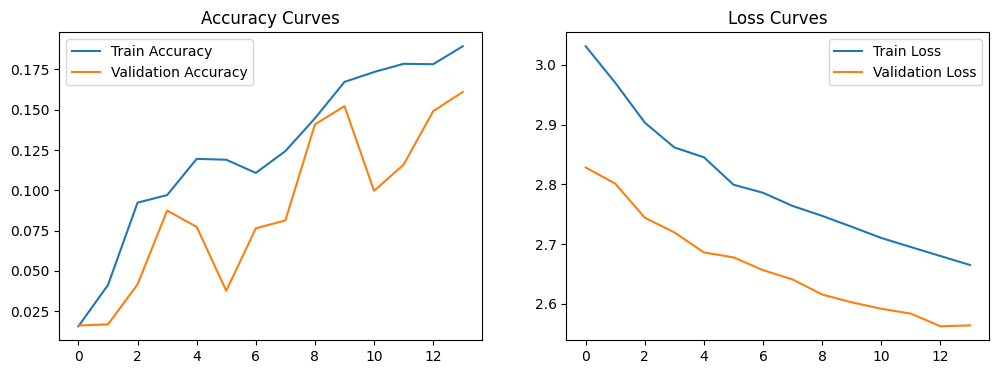

In [ ]:
# Cell 7: Plot training metrics
# Plot accuracy and loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [ ]:
# Cell 8: Evaluate with mIoU
# Calculate mean Intersection over Union (mIoU)
from tensorflow.keras.metrics import MeanIoU
miou = MeanIoU(num_classes=21)

# Collect validation data
val_images = []
val_masks = []
for images, masks in val_dataset:
    val_images.append(images.numpy())  # Append as batch, not individual images
    val_masks.append(masks.numpy())

# Concatenate batches into single arrays
val_images = np.concatenate(val_images, axis=0)
val_masks = np.concatenate(val_masks, axis=0)

# Predict on validation set
pred_masks = model.predict(val_images)

# Compute mIoU
miou.update_state(val_masks, pred_masks.argmax(-1))
print(f"Mean IoU: {miou.result().numpy()}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step
Mean IoU: 0.03434384614229202


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


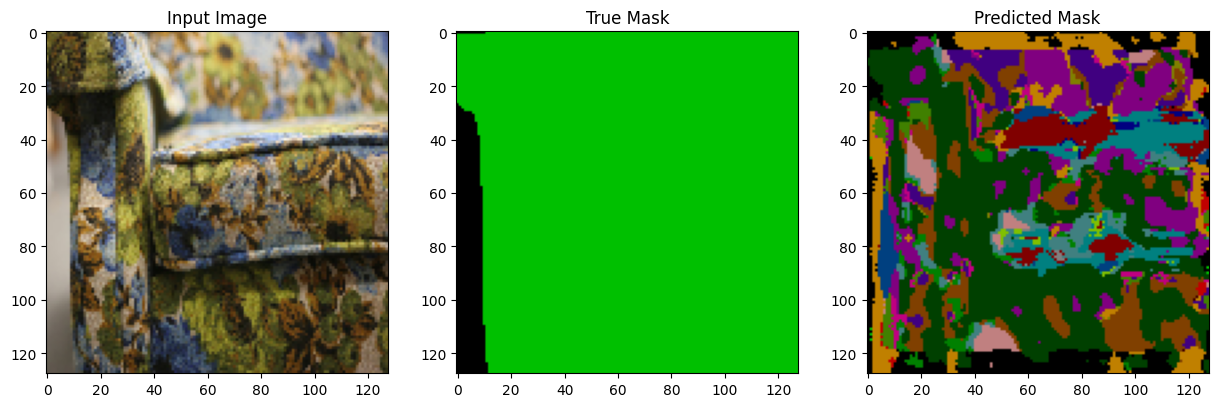

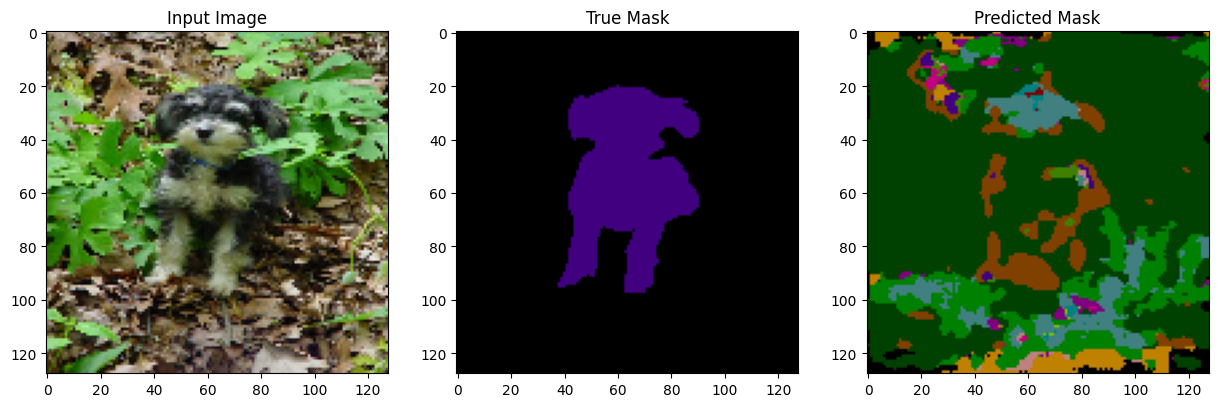

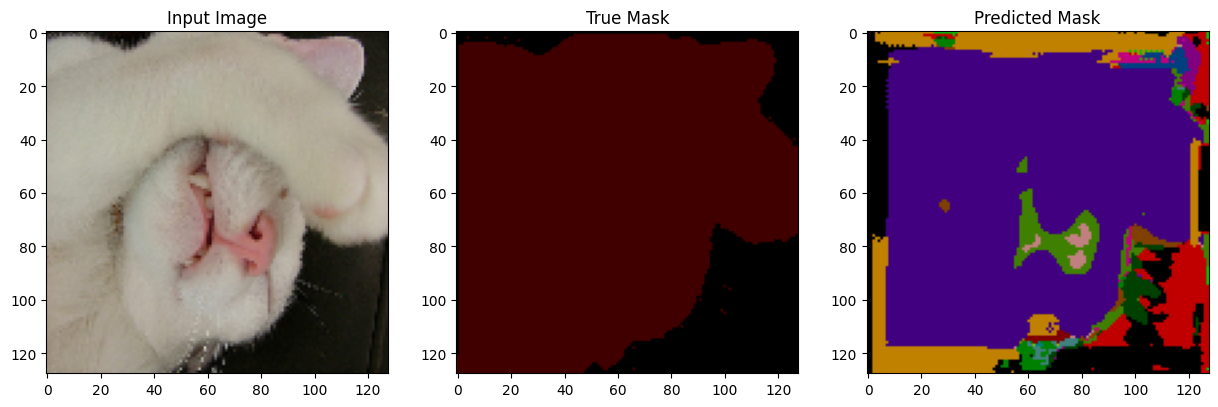

In [ ]:
# Cell 9: Visualize predictions
# Visualize sample predictions
import matplotlib.pyplot as plt

def display_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Input Image')

    plt.subplot(1,3,2)
    plt.imshow(class_indices_to_rgb(true_mask))
    plt.title('True Mask')

    plt.subplot(1,3,3)
    plt.imshow(class_indices_to_rgb(pred_mask))
    plt.title('Predicted Mask')
    plt.show()

# Show predictions
for images, masks in val_dataset.take(1):
    pred_masks = model.predict(images)
    for i in range(3):
        display_prediction(images[i], masks[i], pred_masks[i].argmax(-1))

In [ ]:
# Cell 10: Save and load model
# Save and reload the model
model.save('unet_voc2012.h5')
loaded_model = tf.keras.models.load_model('unet_voc2012.h5', custom_objects={'weighted_sparse_categorical_crossentropy': weighted_sparse_categorical_crossentropy})

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


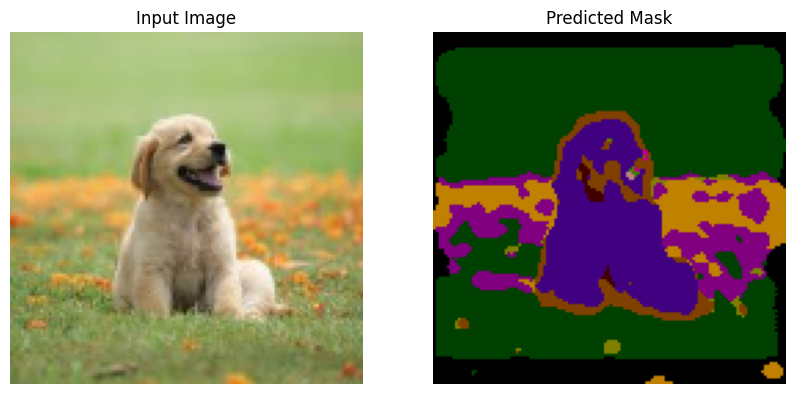

In [ ]:
# Cell 11: Inference on new image
# Preprocess and predict on a new image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image.astype(np.float32) / 255.0
    return image

# Test on a sample image
new_image = preprocess_image('/content/images (1).jpeg')
pred_mask = loaded_model.predict(np.expand_dims(new_image, axis=0))[0].argmax(-1)

# Display result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(new_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(class_indices_to_rgb(pred_mask))
plt.title('Predicted Mask')
plt.axis('off')
plt.show()